# Test projecting of timing model

Assume we have time series data consisting of two deterministic models and noise added linearly,

\begin{equation}
    d \sim M_1 + M_2 + n\;.
\end{equation}

Model 1 is a sine wave and model 2 is a quadratic. The noise is drawn from a zero-mean Gaussian with fixed standard deviation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap
import jax.numpy as jnp
import jax.random as jr

import numpyro
import numpyro.distributions as dist

from emcee.autocorr import integrated_time
import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

## Simulate data

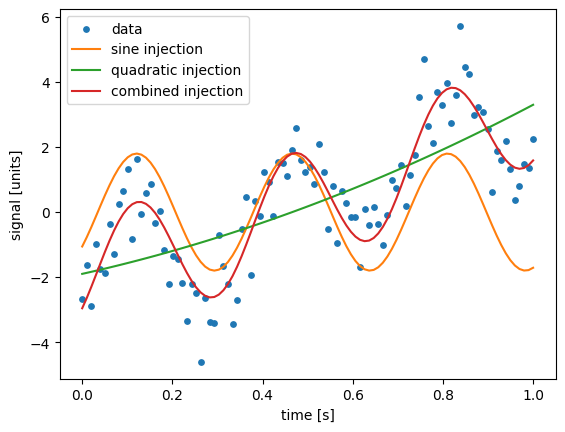

In [2]:
# time samples
Nt = 100
times = jnp.linspace(0., 1., Nt)

# sine wave model
@jit
def sine_model(x_sine):
    # unpack parameters
    amp, freq, phase = x_sine
    return amp * jnp.sin(2. * jnp.pi * freq * times - phase)
vectorized_sine_model = jit(vmap(sine_model))

# quadratic model
@jit
def quadratic_model(x_quadratic):
    # unpack parameters
    a, b, c = x_quadratic
    return a * times**2. + b * times + c
vectorized_quadratic_model = jit(vmap(quadratic_model))

# injected signals
x_sine_inj = jnp.array([1.8, 2.9, jnp.pi / 5.])
x_quadratic_inj = jnp.array([2.1, 3.1, -1.9])
sine_signal_inj = sine_model(x_sine_inj)
quadratic_signal_inj = quadratic_model(x_quadratic_inj)

# add noise
noise_seed = 2
sigma_inj = 0.8
noise = jr.normal(jr.key(noise_seed), shape=(Nt,)) * sigma_inj

# simulate data and plot
data = sine_signal_inj + quadratic_signal_inj + noise
plt.scatter(times, data, color='C0', s=15, label='data')
plt.plot(times, sine_signal_inj, color='C1', label='sine injection')
plt.plot(times, quadratic_signal_inj, color='C2', label='quadratic injection')
plt.plot(times, sine_signal_inj + quadratic_signal_inj, color='C3', label='combined injection')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend()
plt.show()

## Model both signals simultaneously

In [3]:
# parameter labels
x_sine_labels = np.array([r'$A$', r'$f$', r'$\phi$'])
x_quadratic_labels = np.array([r'$a$', r'$b$', r'$c$'])
sigma_label = r'$\sigma$'

# parameter bounds
x_sine_mins = jnp.array([-10., 0., -jnp.pi / 2.])
x_sine_maxs = jnp.array([10., 10., jnp.pi / 2.])
x_quadratic_mins = jnp.array([-10., -10., -10.])
x_quadratic_maxs = jnp.array([10., 10., 10.])
sigma_min = 0.
sigma_max = 10.

# labels and injected values
simul_x_labels = np.concatenate((x_sine_labels, x_quadratic_labels, np.array([sigma_label])))
simul_x_inj = jnp.concatenate((x_sine_inj, x_quadratic_inj, jnp.array([sigma_inj])))

In [4]:
# simultaneous likelihood for both models
@jit
def simul_lnlike(x_sine, x_quadratic, sigma):
    residuals = data - sine_model(x_sine) - quadratic_model(x_quadratic)
    return -0.5 * jnp.sum(residuals**2.) / sigma**2. - Nt * jnp.log(sigma)
vectorized_simul_lnlike = jit(vmap(simul_lnlike))

In [5]:
# sample with NumPyro NUTS
def simul_sampling_model():
    # uniform prior on all parameters
    x_sine = numpyro.sample('x_sine', dist.Uniform(x_sine_mins, x_sine_maxs))
    x_quadratic = numpyro.sample('x_quadratic', dist.Uniform(x_quadratic_mins, x_quadratic_maxs))
    sigma = numpyro.sample('sigma', dist.Uniform(sigma_min, sigma_max))
    # likelihood
    numpyro.factor('ln_likelihood', simul_lnlike(x_sine, x_quadratic, sigma))

# initialization
init_strategy = numpyro.infer.initialization.init_to_value(values={'x_sine':x_sine_inj,
                                                                   'x_quadratic':x_quadratic_inj,
                                                                   'sigma':sigma_inj})

# do MCMC
simul_nuts_kernel = numpyro.infer.NUTS(simul_sampling_model,
                                       init_strategy=init_strategy,
                                       )
simul_mcmc = numpyro.infer.MCMC(sampler=simul_nuts_kernel,
                                num_warmup=int(1e4),
                                num_samples=int(1e5))
simul_mcmc.run(jr.key(0))
simul_samples_dict = simul_mcmc.get_samples()

# convert sample dictionary to array
simul_samples = np.concatenate((simul_samples_dict['x_sine'],
                                simul_samples_dict['x_quadratic'],
                                simul_samples_dict['sigma'][:, None]), axis=1)

sample: 100%|██████████| 110000/110000 [00:35<00:00, 3122.17it/s, 31 steps of size 9.43e-02. acc. prob=0.93]


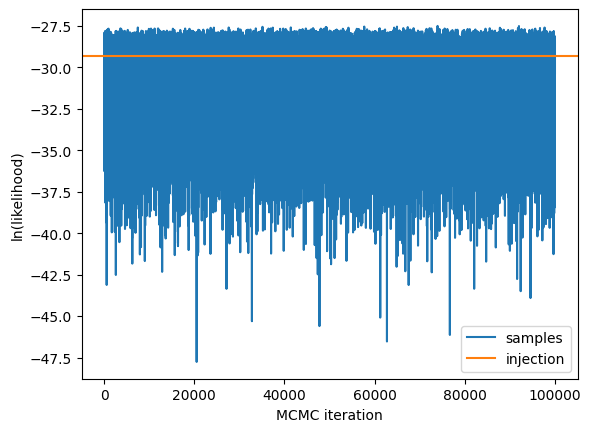

In [6]:
# likelihood values
lnlikes = vectorized_simul_lnlike(simul_samples[:, :3],
                                  simul_samples[:, 3:-1],
                                  simul_samples[:, -1])

plt.plot(lnlikes, label='samples')
plt.axhline(simul_lnlike(x_sine_inj, x_quadratic_inj, sigma_inj), color='C1', label='injection')
plt.xlabel('MCMC iteration')
plt.ylabel('ln(likelihood)')
plt.legend()
plt.show()

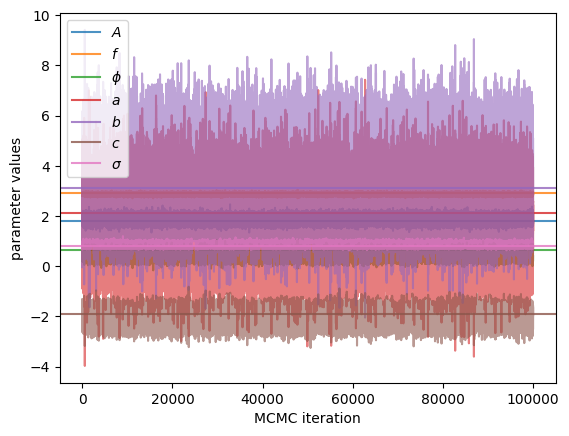

In [7]:
# trace plot
for i in range(simul_x_inj.shape[0]):
    plt.plot(simul_samples[:, i], color=f'C{i}', alpha=0.6)
    plt.axhline(simul_x_inj[i], color=f'C{i}', alpha=0.8, label=simul_x_labels[i])
plt.xlabel('MCMC iteration')
plt.ylabel('parameter values')
plt.legend()
plt.show()

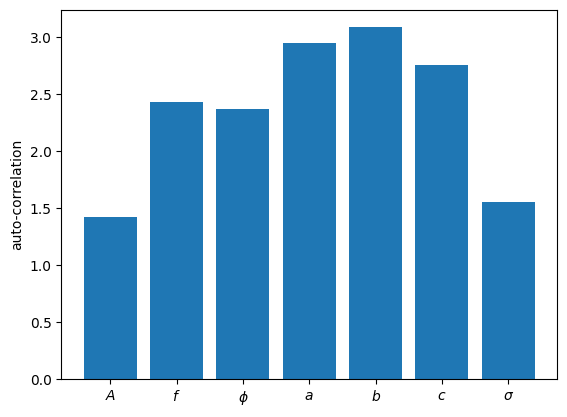

In [8]:
# auto-correlation of chain
plt.bar(simul_x_labels, [integrated_time(samps)[0] for samps in simul_samples.T])
plt.ylabel('auto-correlation')
plt.show()

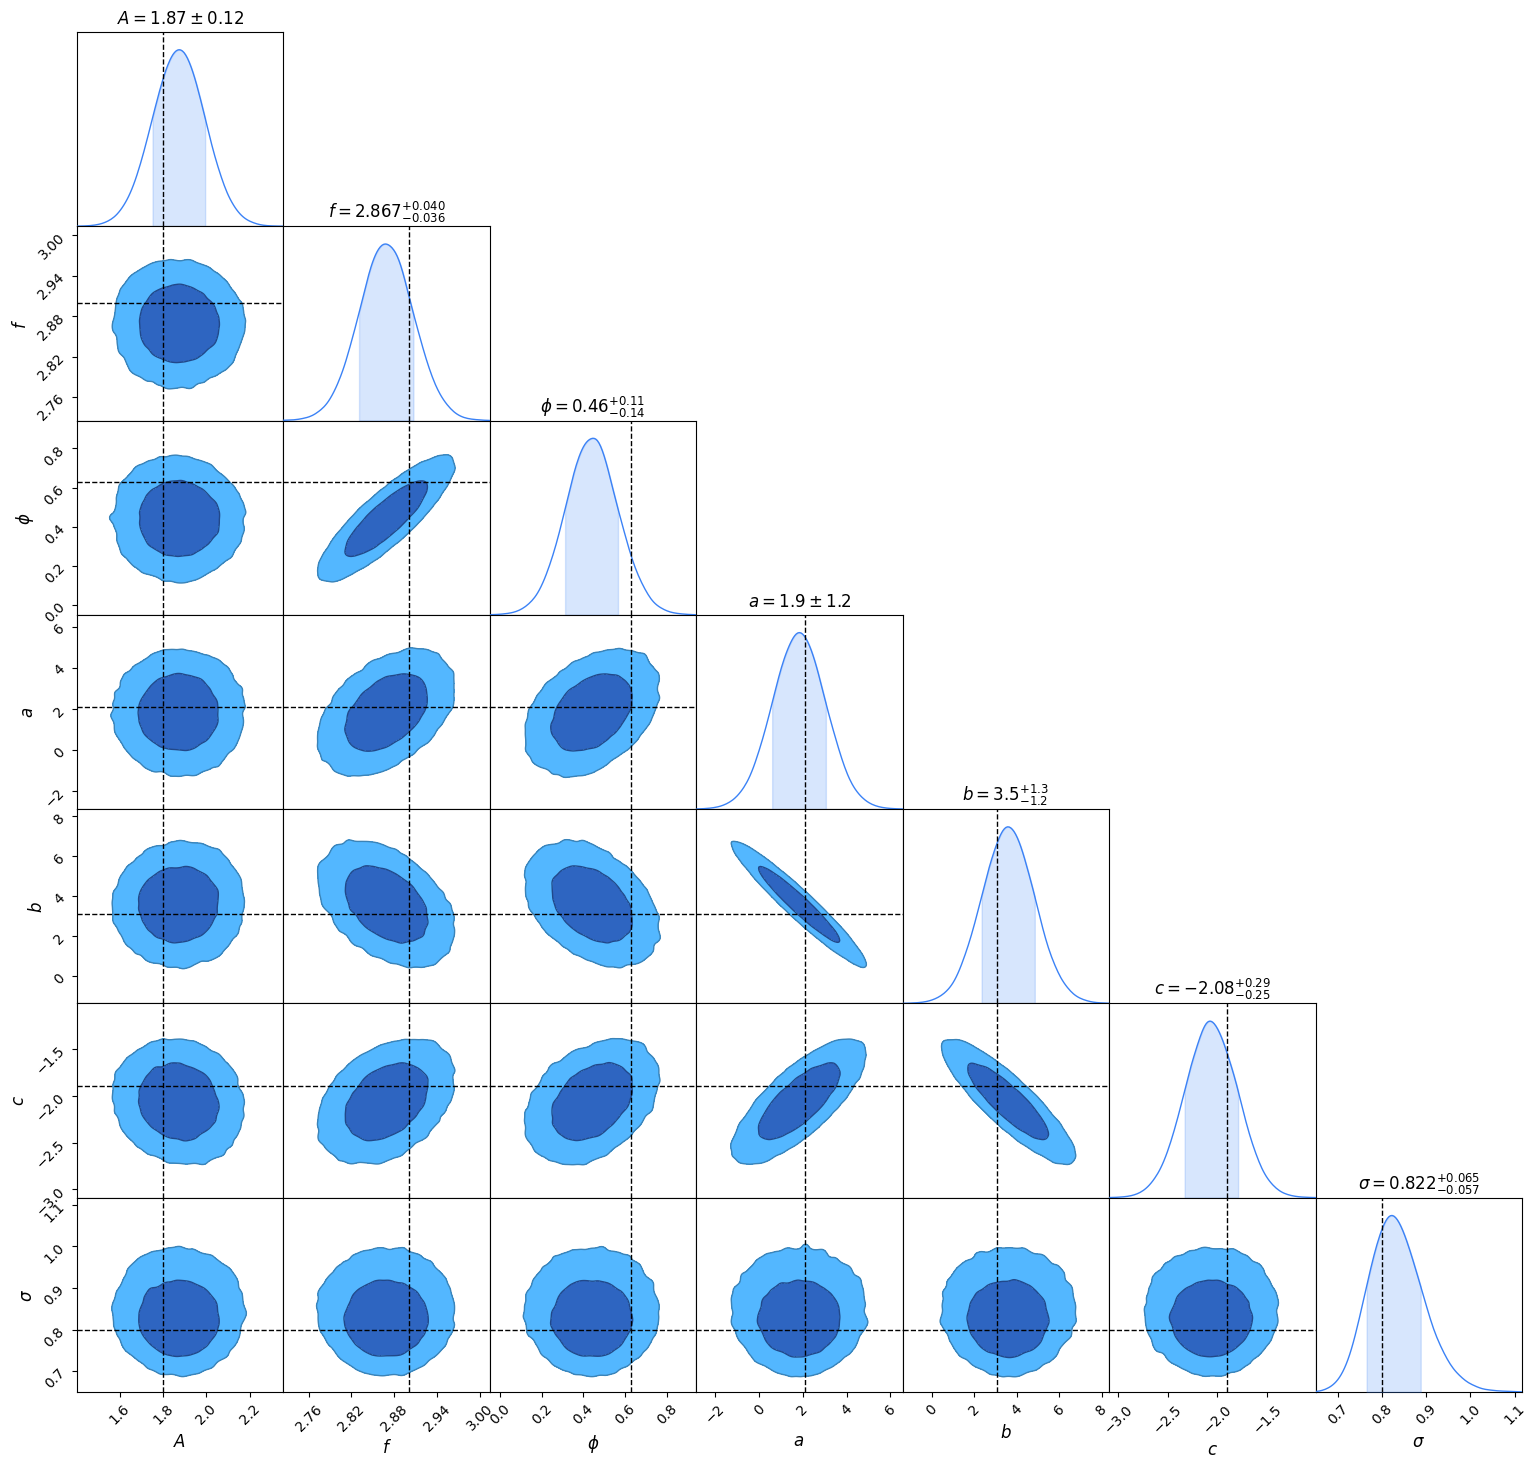

In [9]:
# corner plot
simul_df = pd.DataFrame(simul_samples, columns=simul_x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=simul_df, name='simultaneous modeling'))
c.add_truth(Truth(location={name: val for name, val in zip(simul_x_labels, simul_x_inj)}))
fig = c.plotter.plot()

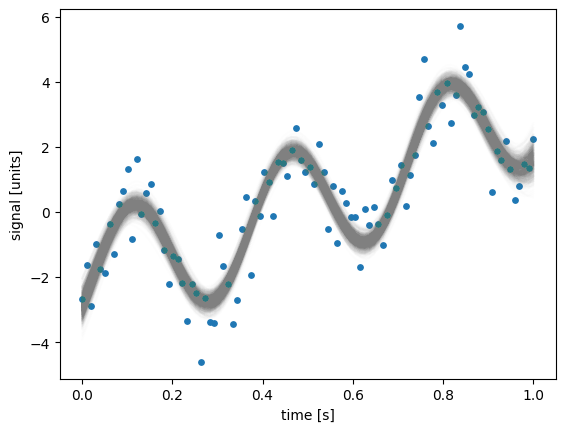

In [10]:
# Bayesogram
fair_draw_ndxs = jr.choice(jr.key(0), simul_samples.shape[0], (1000,))
signals = np.array([sine_model(samp[:3]) + quadratic_model(samp[3:-1])
                    for samp in simul_samples[fair_draw_ndxs]])
plt.scatter(times, data, color='C0', label='data', s=15)
_ = [plt.plot(times, signal, color='grey', alpha=0.01) for signal in signals]
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.show()

## Project data orthogonal to quadratic model

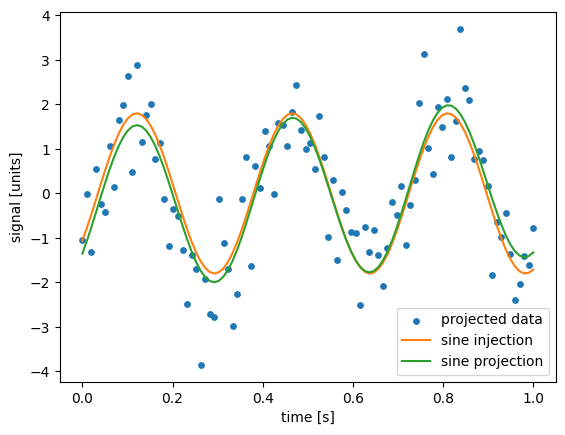

In [25]:
# matrix describing (linear) quadratic model: quadratic = M @ x_quad
M = jnp.vstack((jnp.ones(Nt),
                times,
                times**2)).T

# projection matrix
R = jnp.eye(Nt) - M @ jnp.linalg.inv(M.T @ M) @ M.T

# plot data after projection
data_projected = R @ data
plt.scatter(times, data_projected, color='C0', label='projected data', s=15)
plt.plot(times, sine_signal_inj, color='C1', label='sine injection')
plt.plot(times, R @ sine_signal_inj, color='C2', label='sine projection')
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.show()

## Model projected data

In [80]:
# likelihood for sine model only
# @jit
# def sine_lnlike(x_sine, sigma):
#     residuals = data_projected - sine_model(x_sine)
#     return -0.5 * jnp.sum(residuals**2.) / sigma**2. - Nt * jnp.log(sigma)
# vectorized_sine_lnlike = jit(vmap(sine_lnlike))

# get G matrix
G = jnp.linalg.svd(M).U.T[3:].T


N_marg0 = G.T @ jnp.eye(Nt) @ G
N_marg_inv0 = G @ jnp.linalg.inv(N_marg0) @ G.T
L_N_marg0 = jnp.linalg.cholesky(N_marg0, upper=False)
ln_det_N_marg0 = 2. * jnp.sum(jnp.log(jnp.diag(L_N_marg0)))


@jit
def sine_lnlike(x_sine, sigma):
    residuals = data - sine_model(x_sine)
    return -0.5 * residuals.T @ N_marg_inv0 @ residuals / sigma**2. - (Nt - 3.) * jnp.log(sigma)
vectorized_sine_lnlike = jit(vmap(sine_lnlike))

In [81]:
# sample with NumPyro NUTS
def sine_sampling_model():
    # uniform prior on sine and noise parameters
    x_sine = numpyro.sample('x_sine', dist.Uniform(x_sine_mins, x_sine_maxs))
    sigma = numpyro.sample('sigma', dist.Uniform(sigma_min, sigma_max))
    # likelihood
    numpyro.factor('ln_likelihood', sine_lnlike(x_sine, sigma))

# initialization
init_strategy = numpyro.infer.initialization.init_to_value(values={'x_sine':x_sine_inj,
                                                                   'sigma':sigma_inj})

# do MCMC
sine_nuts_kernel = numpyro.infer.NUTS(sine_sampling_model,
                                       init_strategy=init_strategy,
                                       )
sine_mcmc = numpyro.infer.MCMC(sampler=sine_nuts_kernel,
                               num_warmup=int(1e4),
                               num_samples=int(1e5))
sine_mcmc.run(jr.key(1))
sine_samples_dict = sine_mcmc.get_samples()

# convert sample dictionary to array
sine_samples = np.concatenate((sine_samples_dict['x_sine'],
                               sine_samples_dict['sigma'][:, None]), axis=1)

sample: 100%|██████████| 110000/110000 [00:23<00:00, 4646.88it/s, 15 steps of size 3.19e-01. acc. prob=0.95]


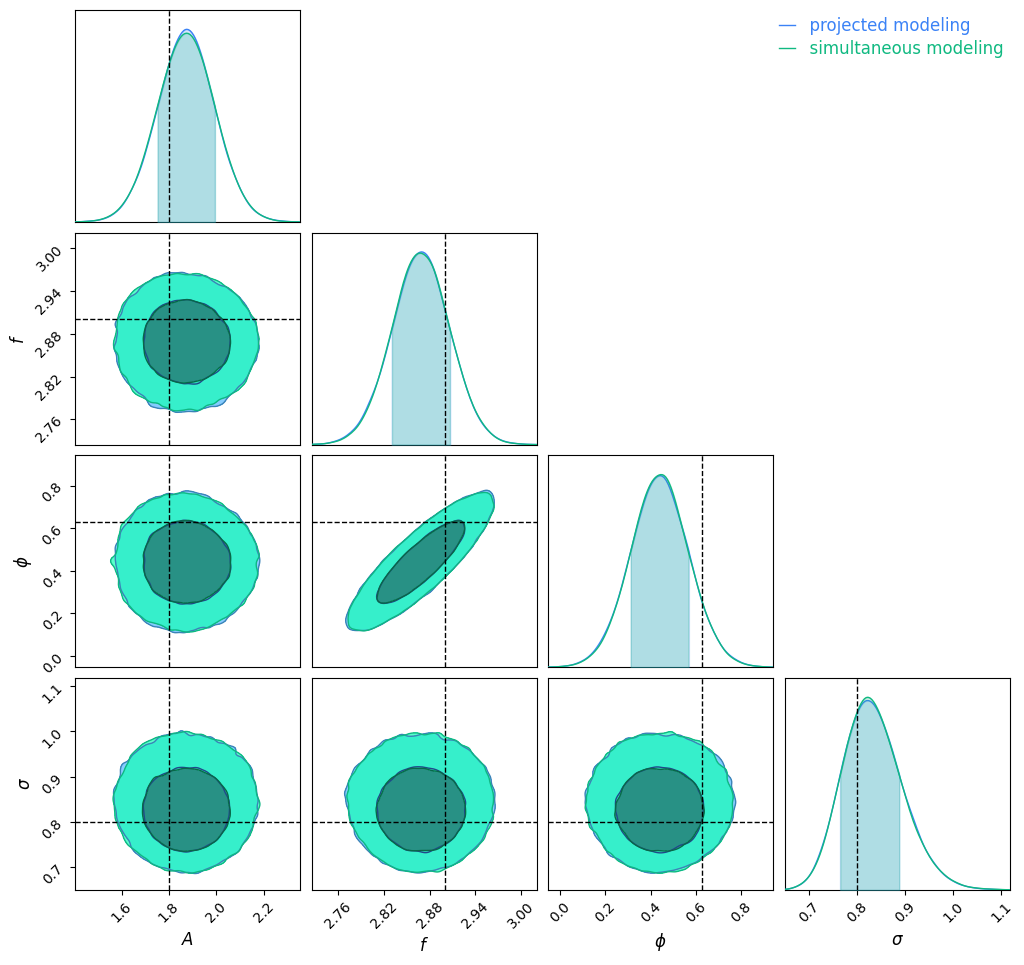

In [82]:
# corner plot
sine_noise_labels = np.concatenate((x_sine_labels, np.array([sigma_label])))
x_sine_noise_inj = jnp.concatenate((x_sine_inj, jnp.array([sigma_inj])))
sine_df = pd.DataFrame(sine_samples, columns=sine_noise_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=sine_df, name='projected modeling'))
c.add_chain(Chain(samples=simul_df.iloc[:, np.concatenate((np.r_[:3], np.r_[-1]))],
                  name='simultaneous modeling'))
c.add_truth(Truth(location={name: val for name, val in zip(sine_noise_labels, x_sine_noise_inj)}))
fig = c.plotter.plot()